# Example 6 : TS with Geopsy Profiles

Time series analysis to compute surface response spectrum and site 
amplification functions using velocity profiles from [geopsy](http://www.geopsy.org/).

In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np

import pysra

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams['figure.dpi'] = 120

## Function to parse the geospy files

In [3]:
def iter_geopsy_profiles(fname):
    """Read a Geopsy formatted text file created by gpdcreport."""
    with open(fname) as fp:
        next(fp)
        while True:
            try:
                line = next(fp)
            except StopIteration:
                break

            m = re.search(r'Layered model (\d+): value=([0-9.]+)', line)
            id, score = m.groups()
            count = int(next(fp))
            d = {
                'id': id,
                'score': score,
                'layers': [],
            }
            cols = ['thickness', 'vel_comp', 'vel_shear', 'density']
            for _ in range(count):
                values = [float(p) for p in next(fp).split()]
                d['layers'].append(dict(zip(cols, values)))

            yield d

## Create the input motion

In [4]:
fname = 'data/NIS090.AT2'
ts = pysra.motion.TimeSeriesMotion.load_at2_file(fname)
ts.accels

array([2.33833e-07, 2.99033e-07, 5.15835e-07, ..., 4.90601e-05,
       4.94028e-05, 4.96963e-05])

## Create the site response calculator

In [5]:
calc = pysra.propagation.LinearElasticCalculator()

## Specify the output

In [6]:
freqs = np.logspace(-1, 2, num=500)

outputs = pysra.output.OutputCollection([
    pysra.output.ResponseSpectrumOutput(
        # Frequency
        freqs,
        # Location of the output
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
    pysra.output.ResponseSpectrumRatioOutput(
        # Frequency
        freqs,
        # Location in (denominator),
        pysra.output.OutputLocation('outcrop', index=-1),
        # Location out (numerator)
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
])

## Create site profiles

Iterate over the geopsy profiles and create a site profile. For this example, we just use a linear elastic properties.

In [7]:
fname = 'data/best100_GM_linux.txt'

for geopsy_profile in iter_geopsy_profiles(fname):
    profile = pysra.site.Profile([
        pysra.site.Layer(
            pysra.site.SoilType(
                'soil-%d' % i, l['density'] / pysra.site.GRAVITY,
                damping=0.05), l['thickness'], l['vel_shear'])
        for i, l in enumerate(geopsy_profile['layers'])
    ])
    # Use 1% damping for the half-space
    profile[-1].soil_type.damping = 0.01
    # Compute the waves from the last layer
    calc(ts, profile, profile.location('outcrop', index=-1))
    # Compute the site amplification
    outputs(calc)

## Plot the outputs

Create a few plots of the output.

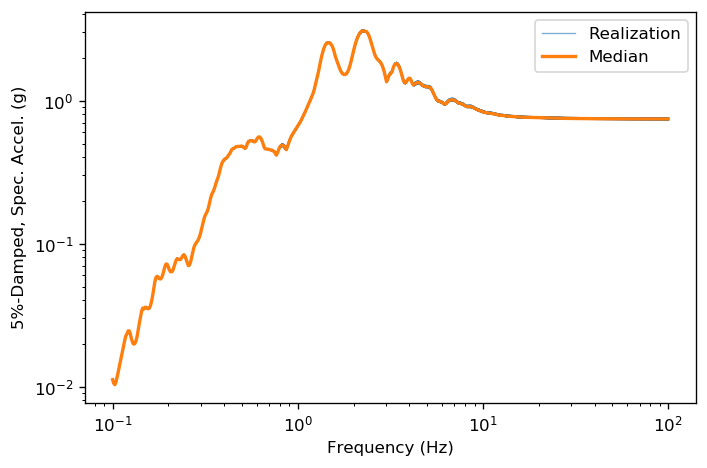

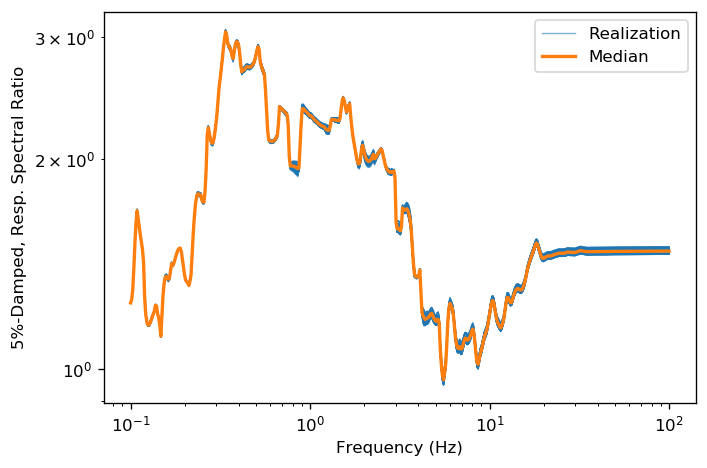

In [8]:
for o in outputs:
    o.plot()